# Attention Is All You Need
---

In [25]:
import math

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin

https://arxiv.org/pdf/1902.06068

Published: 2 Aug 2023

---
## 1. Introduction

- **Recurrent Neural Networks (RNNs)**, including **Long Short-Term Memory (LSTM)** [13] and **Gated Recurrent Units (GRU)** [7], are widely used in **sequence modeling** and **transduction tasks** like **language modeling** and **machine translation** [35, 2, 5].  
- Research has advanced **encoder-decoder architectures** [38, 24, 15].  

#### Limitations of Recurrent Models
- RNNs process sequences **sequentially**, generating hidden states \( h_t \) based on the previous state \( h_{t-1} \) and input at position \( t \).  
- This limits **parallelization** during training, especially for long sequences, due to **memory constraints**.  
- Some approaches, such as **factorization tricks** [21] and **conditional computation** [32], improve efficiency but do not eliminate the sequential dependency.  

#### Role of Attention Mechanisms
- **Attention mechanisms** allow models to **capture dependencies** regardless of **distance** in input/output sequences [2, 19].  
- However, they are **mostly used alongside recurrent networks** [27].  

#### The Transformer
- **The Transformer** introduces an architecture that **removes recurrence** and relies **entirely on attention mechanisms** to model **global dependencies**.  
- This enables **significantly more parallelization** and **improves performance**.

---
## 2. Background

#### Reducing Sequential Computation
- Several models aim to reduce sequential computation by using **convolutional neural networks (CNNs)**, including:
  - **Extended Neural GPU** [16]
  - **ByteNet** [18]
  - **ConvS2S** [9]
- These models compute hidden representations **in parallel** but require **more operations** to relate distant input/output positions:
  - **ConvS2S** → Linear growth
  - **ByteNet** → Logarithmic growth
- **The Transformer** reduces this to **a constant number of operations**, but may lower resolution due to **averaging attention-weighted positions**.  
  - This issue is mitigated using **Multi-Head Attention** (see Sectio##n 3.2).

## Self-Attention Mechanism
- **Self-attention (intra-attention)** relates different positions within a sequence to compute its representation.  
- Successfully applied in:
  - **Reading comprehension**
  - **Abstractive summarization**
  - **Textual entailment**
  - **Task-independent sentence representations** ##[4, 27, 28, 22]

## End-to-End Memory Networks
- Use a **recurrent attention mechanism** instead of sequence-aligned recurrence.  
- Effective in **question answering** and **language mod##eling** tasks [34].

## The Transformer’s Novelty
- **First transduction model** to rely **entirely on self-attention** for input/output representation.
- Unlike previous models [17, 18, 9], **it does not use RNNs or CNNs** for sequence alignment.
- The next sections discuss **self-attention's advntages** over these models.


---
## 3. Model Architecture

#### Encoder-Decoder Structure
- Most **neural sequence transduction models** follow an **encoder-decoder** structure [5, 2, 35].
- **Encoder** maps input sequence \( (x_1, ..., x_n) \) to continuous representations \( z = (z_1, ..., z_n) \).
- **Decoder** generates output \( (y_1, ..., y_m) \) auto-regressively, consuming previously generated symbols.

#### The Transformer Architecture
- Uses **stacked self-attention** and **point-wise feed-forward layers** for **both** encoder and decoder.
- More parallelization compared to recurrent models.

#### Encoder and Decoder Stacks
##### Encoder:
- **6 identical layers**, each with:
  - **Multi-head self-attention**.
  - **Position-wise fully connected feed-forward network**.
  - **Residual connections** + **Layer Normalization**.
- All layers output **512-dimensional representations**.

##### Decoder:
- **6 identical layers**, each with:
  - **Multi-head self-attention**.
  - **Feed-forward network**.
  - **Encoder-decoder attention** (queries from decoder, keys/values from encoder output).
  - **Masked self-attention** to prevent seeing future tokens.
- Uses residual connections and layer normalization.

#### Attention Mechanism
- **Maps queries, keys, and values** to an output based on a compatibility function.
- Computed as a **weighted sum of values**, where weights depend on the query-key relationship.

##### 3.2.1 Scaled Dot-Product Attention
$$
\text{Attention}(Q, K, V) = \text{softmax} \left( \frac{QK^T}{\sqrt{d_k}} \right) V
$$
- **Scaling by** \( \sqrt{d_k} \) prevents extremely small gradients for large \( d_k \).

##### 3.2.2 Multi-Head Attention
- Instead of a single attention function, multiple attention heads project queries, keys, and values independently:
$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h) W^O
$$
$$
\text{head}_i = \text{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$$
- **Uses 8 parallel attention heads**, each with **\( d_k = d_v = 64 \)**.

#### Applications of Attention
- **Encoder-Decoder Attention**: Decoder attends to all encoder positions.
- **Encoder Self-Attention**: Each token attends to all previous tokens.
- **Masked Decoder Self-Attention**: Prevents leftward information flow.

#### 3.3 Position-wise Feed-Forward Networks
- Each encoder/decoder layer contains:
$$
\text{FFN}(x) = \max(0, xW_1 + b_1) W_2 + b_2
$$
- **512-dimensional input/output**, **2048-dimensional inner layer**.

#### 3.4 Embeddings and Softmax
- Input/output tokens are converted to **512-dimensional embeddings**.
- **Softmax function** predicts next-token probabilities.
- Weight sharing between embedding and pre-softmax transformation.

#### 3.5 Positional Encoding
- Since **no recurrence or convolution**, position information is added via **sinusoidal encodings**:
$$
PE(pos, 2i) = \sin \left(\frac{pos}{10000^{2i/d_{\text{model}}}} \right)
$$
$$
PE(pos, 2i+1) = \cos \left(\frac{pos}{10000^{2i/d_{\text{model}}}} \right)
$$
- Enables the model to **learn relative positional information**.
- **Learned positional embeddings** give similar results.

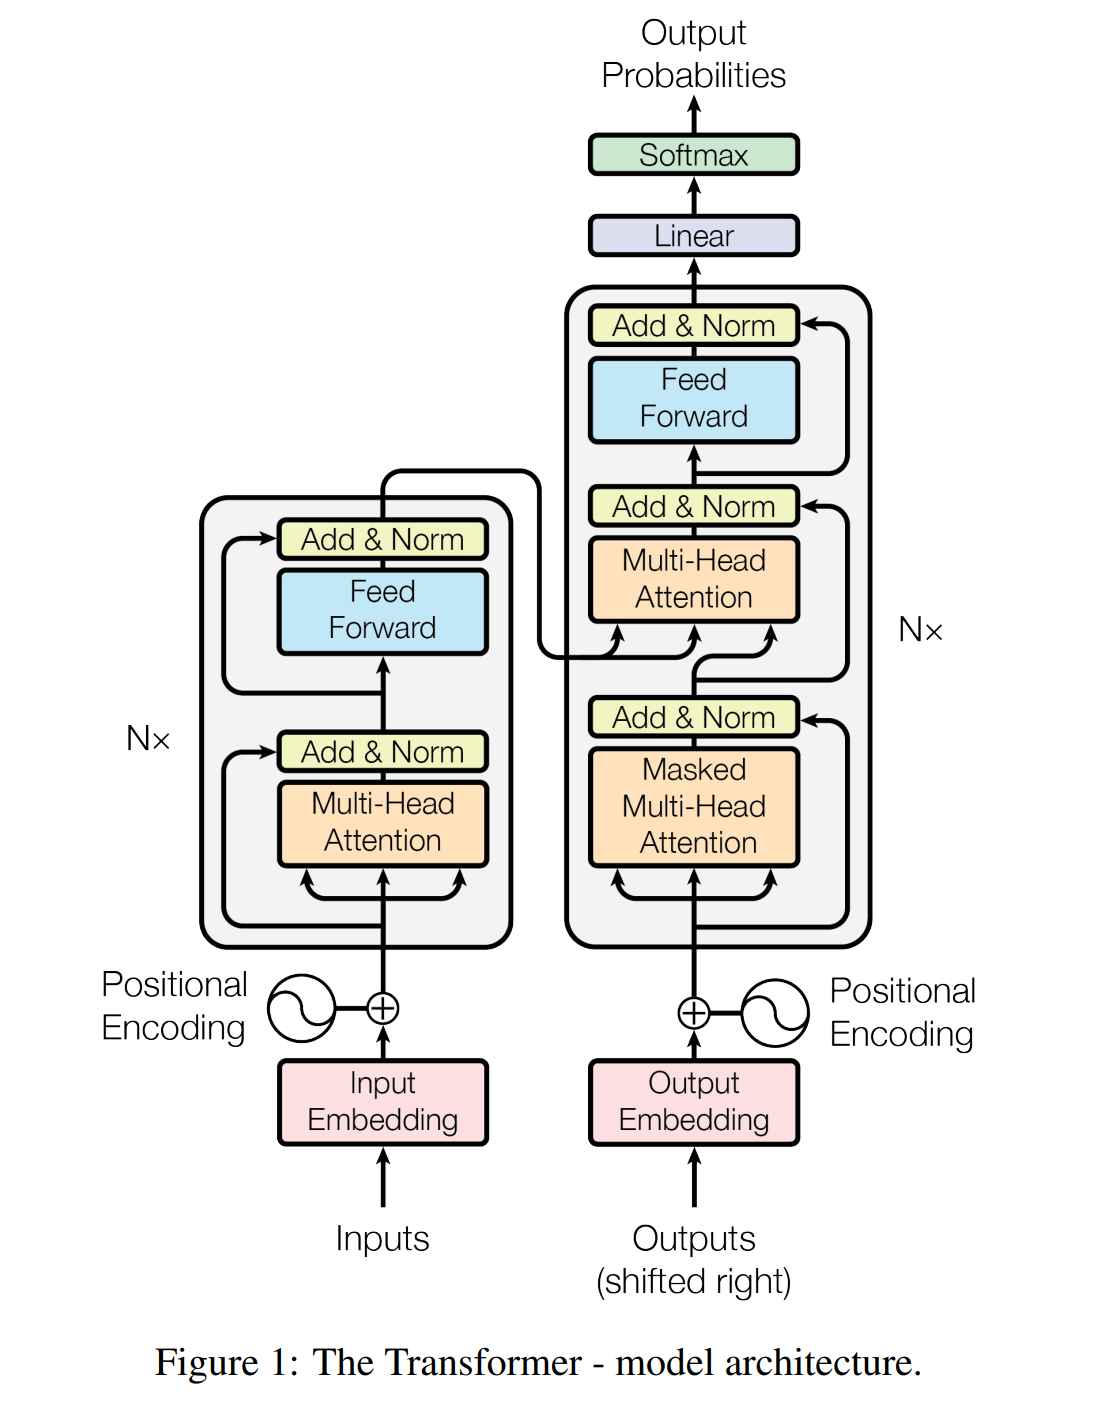

In [4]:
display(Image(filename="figure_one.png", width=500))

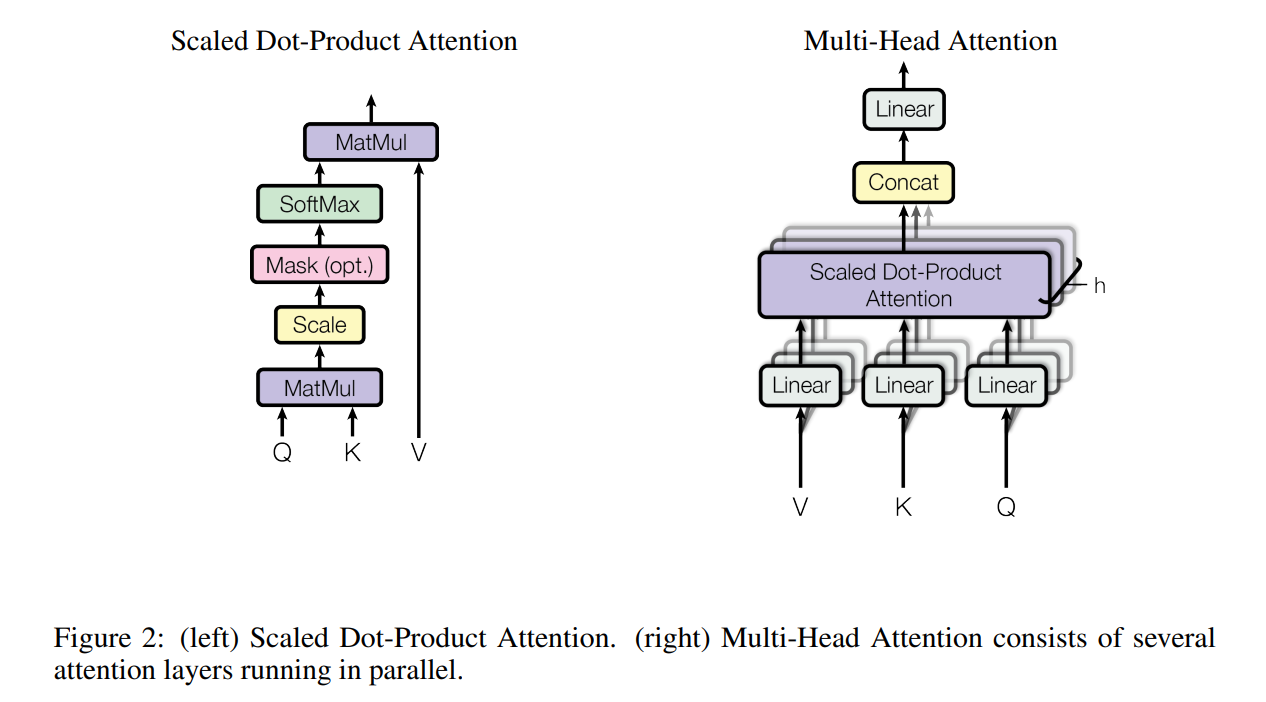

In [6]:
display(Image(filename="figure_two.png", width=700))

---
## 4. Why Self-Attention

#### Comparison with Recurrent and Convolutional Layers
Self-attention is compared to recurrent and convolutional layers for mapping sequences \( (x_1, ..., x_n) \) to \( (z_1, ..., z_n) \). The comparison is based on:

1. **Computational Complexity per Layer** – Total operations required.
2. **Parallelization** – Minimum sequential operations needed.
3. **Path Length for Long-Range Dependencies** – Shorter paths improve learning efficien##cy.

## Advantages of Self-Attention
- **Constant path length** between all input-output positions, whereas RNNs require **\( O(n) \)** sequential operations.
- **More efficient than RNNs** when sequence length \( n \) is smaller than representation dimensionality \( d \).
- For very long sequences, restricting attention to a neighborhood of size \( r \) increases path length to **\( O(n/##r) \)**.

## Comparison with Convolutional Layers
- **Single convolutional layers** with kernel width \( k \) do not connect all input-output positions.
- Requires stacking **\( O(n/k) \)** contiguous layers or **\( O(\log_k(n)) \)** dilated layers.
- **Computational cost**:
  - Convolutional layers are **\( k \)-times more expensive than recurrent layers**.
  - **Separable convolutions** reduce complexity to \( O(k \cdot n \cdot d + n \cdot d^2) \), but still match self-at##tention's cost.

## Interpretability of Self-Attention
- Self-attention allows for **more interpretable models**.
- Attention heads learn distinct tasks and capture **syntactic and semantic structure**.
- Examples of attention patterns are aalyzed in the appendix.


---
## 5. Training

#### 5.1 Training Data and Batching
- **Datasets:**
  - **WMT 2014 English-German**: ~4.5M sentence pairs, **Byte-Pair Encoding (BPE)** with a **37K-token vocabulary**.
  - **WMT 2014 English-French**: 36M sentence pairs, **32K word-piece vocabulary** [38].
- **Batching:**
  - Sentences grouped by approximate length.
  - Each batch contains **~25K source and 25K target tokens**.

#### 5.2 Hardware and Training Schedule
- **Hardware:** 8 × NVIDIA P100 GPUs.
- **Base model:**
  - **Training step:** 0.4 sec.
  - **Total steps:** 100K (~12 hours).
- **Big model:**
  - **Training step:** 1.0 sec.
  - **Total steps:** 300K (~3.5 days).

#### 5.3 Optimizer
- **Adam optimizer** [20] with:
  - \( \beta_1 = 0.9 \), \( \beta_2 = 0.98 \), \( \epsilon = 10^{-9} \).
- **Learning rate schedule:**
  $$
  lrate = d_{\text{model}}^{-0.5} \cdot \min(\text{step\_num}^{-0.5}, \text{step\_num} \cdot \text{warmup\_steps}^{-1.5})
  $$
  - **Warm-up steps:** 4000.
  - **Initial increase**, then decays proportionally to \( \frac{1}{\sqrt{\text{step\_num}}} \).

#### 5.4 Regularization
##### Dropout
- **Applied to:**
  - Output of each sub-layer **before residual addition and normalization**.
  - Sum of embeddings and positional encodings.
- **Dropout rate:** \( P_{\text{drop}} = 0.1 \).

##### Label Smoothing
- **Smoothing factor:** \( \epsilon_{\text{ls}} = 0.1 \) [36].
- **Effect:**
  - Increases model uncertainty (hurts perplexity).
  - Improves **accuracy** and **BLEU score**.

In [16]:
data = {
    "Model": [
        "ByteNet [18]", "Deep-Att + PosUnk [39]", "GNMT + RL [38]", "ConvS2S [9]", "MoE [32]",
        "Deep-Att + PosUnk Ensemble [39]", "GNMT + RL Ensemble [38]", "ConvS2S Ensemble [9]",
        "Transformer (base model)", "Transformer (big)"
    ],
    "BLEU EN-DE": [23.75, None, 24.6, 25.16, 26.03, None, 26.30, 26.36, 27.3, 28.4],
    "BLEU EN-FR": [None, 39.2, 39.92, 40.46, 40.56, 40.4, 41.16, 41.29, 38.1, 41.8],
    "Training Cost EN-DE (FLOPs)": [None, "1.0 × 10^20", "2.3 × 10^19", "9.6 × 10^18", "2.0 × 10^19",
                                     "8.0 × 10^20", "1.8 × 10^20", "7.7 × 10^19", "3.3 × 10^18", "2.3 × 10^19"],
    "Training Cost EN-FR (FLOPs)": [None, "1.4 × 10^20", "1.5 × 10^20", "1.2 × 10^20", None,
                                     None, "1.1 × 10^21", "1.2 × 10^21", None, None]
}

df = pd.DataFrame(data)
display(df)

print('Table 1: The Transformer achieves better BLEU scores than previous state-of-the-art models on the English-to-German and English-to-French newstest2014 tests at a fraction of the training cost.')

,Model,BLEU EN-DE,BLEU EN-FR,Training Cost EN-DE (FLOPs),Training Cost EN-FR (FLOPs)
0,ByteNet [18],23.75,NaN,None,None
1,Deep-Att + PosUnk [39],NaN,39.20,1.0 × 10^20,1.4 × 10^20
2,GNMT + RL [38],24.60,39.92,2.3 × 10^19,1.5 × 10^20
3,ConvS2S [9],25.16,40.46,9.6 × 10^18,1.2 × 10^20
4,MoE [32],26.03,40.56,2.0 × 10^19,None
5,Deep-Att + PosUnk Ensemble [39],NaN,40.40,8.0 × 10^20,None
6,GNMT + RL Ensemble [38],26.30,41.16,1.8 × 10^20,1.1 × 10^21
7,ConvS2S Ensemble [9],26.36,41.29,7.7 × 10^19,1.2 × 10^21
8,Transformer (base model),27.30,38.10,3.3 × 10^18,None
9,Transformer (big),28.40,41.80,2.3 × 10^19,None


Table 1: The Transformer achieves better BLEU scores than previous state-of-the-art models on the English-to-German and English-to-French newstest2014 tests at a fraction of the training cost.


---
## 6. Results

#### 6.1 Machine Translation
- **WMT 2014 English-to-German:**  
  - **Big Transformer Model** achieves **28.4 BLEU**, surpassing previous best models by **2.0 BLEU**.  
  - **Base Model** also outperforms prior models with significantly lower training costs.  
  - Training: **3.5 days on 8 P100 GPUs**.  

- **WMT 2014 English-to-French:**  
  - **Big Model:** **41.0 BLEU**, better than previous single models at **1/4 training cost**.  
  - **Dropout rate:** \( P_{\text{drop}} = 0.1 \) (instead of **0.3**).  

- **Inference Strategy:**  
  - **Checkpoint averaging**: **5 checkpoints for base models**, **20 for big models**.  
  - **Beam search**: **Beam size = 4**, **length penalty \( \alpha = 0.6 \)**.  
  - **Max output length**: \( \text{input length} + 50 \).  

- **Comparison with Other Models:**  
  - **Table 2** compares **translation quality & training costs**.  
  - **Floating point operations (FLOPs)** estimated using **training time × GPUs × FLOP capacity per GPU**.  

#### 6.2 Model Variations
- **Experiments on English-to-German translation (newstest2013 development set).**  
- **Table 3 - Key Observations:**
  - **(A):** Single-head attention **0.9 BLEU worse** than optimal multi-head setup.  
  - **(B):** Smaller **attention key size** \( d_k \) degrades model quality.  
  - **(C, D):** **Larger models perform better**, **dropout prevents overfitting**.  
  - **(E):** **Learned positional embeddings** ≈ **sinusoidal encoding** in performance.  

#### 6.3 English Constituency Parsing
- Evaluated on **Penn Treebank (WSJ section)** with **40K training sentences**.  
- **Semi-supervised setup:**  
  - **17M sentence dataset** (high-confidence + BerkeleyParser corpora).  
  - **Vocabulary:** **16K (WSJ only)**, **32K (semi-supervised)**.  
  - **Beam search:** **Beam size = 21**, **\( \alpha = 0.3 \)**.  
  - **Max output length**: \( \text{input length} + 300 \).  

- **Results (Table 4):**  
  - **Outperforms all models** except **Recurrent Neural Network Grammar (RNNG)** [8].  
  - **Beats BerkeleyParser**, even with **only WSJ training set (40K sentences)**.  

,Parser,Training,WSJ 23 F1
0,Vinyals & Kaiser et al. (2014) [37],"WSJ only, discriminative",88.3
1,Petrov et al. (2006) [29],"WSJ only, discriminative",90.4
2,Zhu et al. (2013) [40],"WSJ only, discriminative",90.4
3,Dyer et al. (2016) [8],"WSJ only, discriminative",91.7
4,Transformer (4 layers),"WSJ only, discriminative",91.3
5,Zhu et al. (2013) [40],semi-supervised,91.3
6,Huang & Harper (2009) [14],semi-supervised,91.3
7,McClosky et al. (2006) [26],semi-supervised,92.1
8,Vinyals & Kaiser et al. (2014) [37],semi-supervised,92.1
9,Transformer (4 layers),semi-supervised,92.7


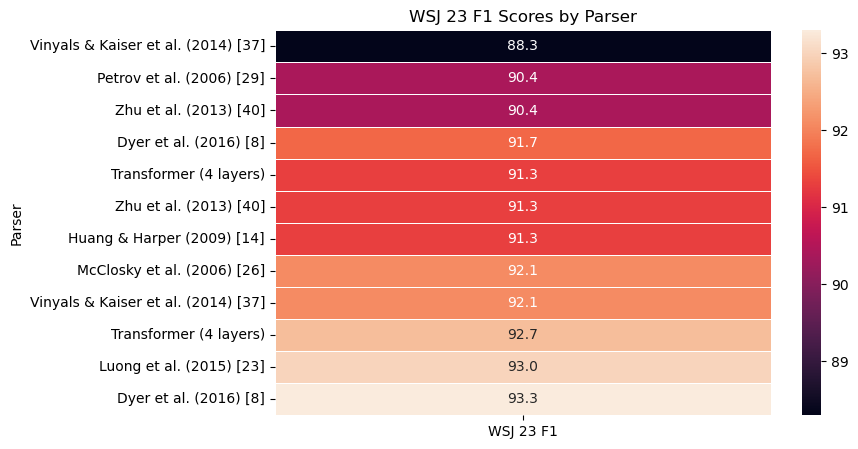

In [18]:
data = {
    "Parser": [
        "Vinyals & Kaiser et al. (2014) [37]", "Petrov et al. (2006) [29]", "Zhu et al. (2013) [40]",
        "Dyer et al. (2016) [8]", "Transformer (4 layers)",
        "Zhu et al. (2013) [40]", "Huang & Harper (2009) [14]", "McClosky et al. (2006) [26]",
        "Vinyals & Kaiser et al. (2014) [37]", "Transformer (4 layers)",
        "Luong et al. (2015) [23]", "Dyer et al. (2016) [8]"
    ],
    "Training": [
        "WSJ only, discriminative", "WSJ only, discriminative", "WSJ only, discriminative",
        "WSJ only, discriminative", "WSJ only, discriminative",
        "semi-supervised", "semi-supervised", "semi-supervised",
        "semi-supervised", "semi-supervised",
        "multi-task", "generative"
    ],
    "WSJ 23 F1": [88.3, 90.4, 90.4, 91.7, 91.3, 91.3, 91.3, 92.1, 92.1, 92.7, 93.0, 93.3]
}

df = pd.DataFrame(data)

from IPython.display import display
display(df)

plt.figure(figsize=(8, 5))
sns.heatmap(df.set_index("Parser")["WSJ 23 F1"].to_frame(), annot=True, fmt=".1f", linewidths=0.5)
plt.title("WSJ 23 F1 Scores by Parser")
plt.show()

---
## Transformer Model Implementation and Training

In [24]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super().__init__()
        self.d_k = d_k
    
    def forward(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        return torch.matmul(attn, V), attn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.attention = ScaledDotProductAttention(self.d_k)
    
    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        attn_output, attn_weights = self.attention(Q, K, V, mask)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        return self.W_o(attn_output)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x, mask)))
        x = self.norm2(x + self.dropout(self.ffn(x)))
        return x

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, enc_output, src_mask=None, tgt_mask=None):
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x, tgt_mask)))
        x = self.norm2(x + self.dropout(self.enc_dec_attn(x, enc_output, enc_output, src_mask)))
        x = self.norm3(x + self.dropout(self.ffn(x)))
        return x

if __name__ == "__main__":
    model = Transformer(d_model=512, num_heads=8, d_ff=2048, num_layers=6, vocab_size=10000)
    src = torch.randint(0, 10000, (10, 32)) 
    tgt = torch.randint(0, 10000, (10, 32))
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(10):
        optimizer.zero_grad()
        output = model(src, tgt)
        loss = criterion(output.view(-1, 10000), tgt.view(-1))
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 9.3981
Epoch 2, Loss: 8.8009
Epoch 3, Loss: 8.4933
Epoch 4, Loss: 8.2488
Epoch 5, Loss: 8.0103
Epoch 6, Loss: 7.6649
Epoch 7, Loss: 7.3036
Epoch 8, Loss: 6.9758
Epoch 9, Loss: 6.6468
Epoch 10, Loss: 6.3341


## **Transformer Code**

#### **1. Key Components**
##### **Scaled Dot-Product Attention**
- Computes attention by performing a **dot product** between `Query (Q)`, `Key (K)`, and `Value (V)`, normalizing by \( \sqrt{d_k} \).
- Uses **Softmax** to generate attention weights.

##### **Multi-Head Attention**
- Splits input vectors into **multiple attention heads**, allowing the model to capture **different aspects** of the input.
- Combines attention outputs through a **linear transformation**.

##### **Position-wise Feed-Forward Network (FFN)**
- Two **fully connected layers** with **ReLU activation**.
- Each token passes through the feed-forward network **independently**.

##### **Positional Encoding**
- Adds **sinusoidal wave patterns** to input embeddings to retain **positional information**.
- Helps the model distinguish between different positions in a sequence.

##### **Encoder Layer**
- Composed of:
  - **Multi-Head Self-Attention**
  - **Feed-Forward Network (FFN)**
  - **Residual Connections** + **Layer Normalization**
- Processes input sequences **in parallel**.

##### **Decoder Layer**
- Similar to the encoder but includes an **additional attention mechanism** over encoder outputs.
- **Masked Self-Attention** prevents the model from seeing future words during training.

##### **Full Transformer Model**
- Consists of:
  - **Input embedding layers**
  - **Positional Encoding**
  - **Stack of Encoder and Decoder layers**
  - **Final linear output layer**

#### **2. Training Process**
- **Generates random training samples** (`src` and `tgt`).
- **Optimizer:** `Adam(lr=0.0001)`
- **Loss function:** `CrossEntropyLoss`
- **Training loop:** 10 epochs
  - **Predicts outputs** using the Transformer model.
  - **Computes loss** with `CrossEntropyLoss`.
  - **Backpropagation to update gradients**.
  - **Weight updates using Adam optimizer**.
  - **Loss is printed at each epoch**.

---
## 7 Conclusion

- **The Transformer** is the **first sequence transduction model** based entirely on **self-attention**, eliminating recurrent layers in encoder-decoder architectures.
- **Faster training** than RNN/CNN-based architectures for **translation tasks**.
- Achieves **state-of-the-art results** on:
  - **WMT 2014 English-to-German** (best model outperforms all previous ensembles).
  - **WMT 2014 English-to-Fregener##ation.

### Code Availability
- Training and evaluation code is available at:  
  [https://github.com/tensorflow/tensor2tensor](https://github.com/tensorflow/ensor2tensor).


## References

[1] Jimmy Lei Ba, Jamie Ryan Kiros, and Geoffrey E Hinton. Layer normalization. *arXiv preprint arXiv:1607.06450*, 2016.  
[2] Dzmitry Bahdanau, Kyunghyun Cho, and Yoshua Bengio. Neural machine translation by jointly learning to align and translate. *CoRR*, abs/1409.0473, 2014.  
[3] Denny Britz, Anna Goldie, Minh-Thang Luong, and Quoc V. Le. Massive exploration of neural machine translation architectures. *CoRR*, abs/1703.03906, 2017.  
[4] Jianpeng Cheng, Li Dong, and Mirella Lapata. Long short-term memory-networks for machine reading. *arXiv preprint arXiv:1601.06733*, 2016.  
[5] Kyunghyun Cho, Bart van Merrienboer, Caglar Gulcehre, Fethi Bougares, Holger Schwenk, and Yoshua Bengio. Learning phrase representations using RNN encoder-decoder for statistical machine translation. *CoRR*, abs/1406.1078, 2014.  
[6] Francois Chollet. Xception: Deep learning with depthwise separable convolutions. *arXiv preprint arXiv:1610.02357*, 2016.  
[7] Junyoung Chung, Çaglar Gülçehre, Kyunghyun Cho, and Yoshua Bengio. Empirical evaluation of gated recurrent neural networks on sequence modeling. *CoRR*, abs/1412.3555, 2014.  
[8] Chris Dyer, Adhiguna Kuncoro, Miguel Ballesteros, and Noah A. Smith. Recurrent neural network grammars. In *Proc. of NAACL*, 2016.  
[9] Jonas Gehring, Michael Auli, David Grangier, Denis Yarats, and Yann N. Dauphin. Convolutional sequence to sequence learning. *arXiv preprint arXiv:1705.03122v2*, 2017.  
[10] Alex Graves. Generating sequences with recurrent neural networks. *arXiv preprint arXiv:1308.0850*, 2013.  
[11] Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Deep residual learning for image recognition. *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition*, 770–778, 2016.  
[12] Sepp Hochreiter, Yoshua Bengio, Paolo Frasconi, and Jürgen Schmidhuber. Gradient flow in recurrent nets: the difficulty of learning long-term dependencies, 2001.  
[13] Sepp Hochreiter and Jürgen Schmidhuber. Long short-term memory. *Neural computation*, 9(8):1735–1780, 1997.  
[14] Zhongqiang Huang and Mary Harper. Self-training PCFG grammars with latent annotations across languages. *Proceedings of the 2009 Conference on Empirical Methods in Natural Language Processing*, 832–841, ACL, 2009.  
[15] Rafal Jozefowicz, Oriol Vinyals, Mike Schuster, Noam Shazeer, and Yonghui Wu. Exploring the limits of language modeling. *arXiv preprint arXiv:1602.02410*, 2016.  
[16] Łukasz Kaiser and Samy Bengio. Can active memory replace attention? In *Advances in Neural Information Processing Systems (NIPS)*, 2016.  
[17] Łukasz Kaiser and Ilya Sutskever. Neural GPUs learn algorithms. In *International Conference on Learning Representations (ICLR)*, 2016.  
[18] Nal Kalchbrenner, Lasse Espeholt, Karen Simonyan, Aaron van den Oord, Alex Graves, and Koray Kavukcuoglu. Neural machine translation in linear time. *arXiv preprint arXiv:1610.10099v2*, 2017.  
[19] Yoon Kim, Carl Denton, Luong Hoang, and Alexander M. Rush. Structured attention networks. In *International Conference on Learning Representations*, 2017.  
[20] Diederik Kingma and Jimmy Ba. Adam: A method for stochastic optimization. In *ICLR*, 2015.  
[21] Oleksii Kuchaiev and Boris Ginsburg. Factorization tricks for LSTM networks. *arXiv preprint arXiv:1703.10722*, 2017.  
[22] Zhouhan Lin, Minwei Feng, Cicero Nogueira dos Santos, Mo Yu, Bing Xiang, Bowen Zhou, and Yoshua Bengio. A structured self-attentive sentence embedding. *arXiv preprint arXiv:1703.03130*, 2017.  
[23] Minh-Thang Luong, Quoc V. Le, Ilya Sutskever, Oriol Vinyals, and Lukasz Kaiser. Multi-task sequence to sequence learning. *arXiv preprint arXiv:1511.06114*, 2015.  
[24] Minh-Thang Luong, Hieu Pham, and Christopher D Manning. Effective approaches to attention-based neural machine translation. *arXiv preprint arXiv:1508.04025*, 2015.  
[25] Mitchell P. Marcus, Mary Ann Marcinkiewicz, and Beatrice Santorini. Building a large annotated corpus of English: The Penn Treebank. *Computational linguistics*, 19(2):313–330, 1993.  
[26] David McClosky, Eugene Charniak, and Mark Johnson. Effective self-training for parsing. *Proceedings of the Human Language Technology Conference of the NAACL*, Main Conference, 152–159, ACL, 2006.  
[27] Ankur Parikh, Oscar Täckström, Dipanjan Das, and Jakob Uszkoreit. A decomposable attention model. In *Empirical Methods in Natural Language Processing*, 2016.  
[28] Romain Paulus, Caiming Xiong, and Richard Socher. A deep reinforced model for abstractive summarization. *arXiv preprint arXiv:1705.04304*, 2017.  
[29] Slav Petrov, Leon Barrett, Romain Thibaux, and Dan Klein. Learning accurate, compact, and interpretable tree annotation. *Proceedings of the 21st International Conference on Computational Linguistics and 44th Annual Meeting of the ACL*, 433–440, ACL, 2006.  
[30] Ofir Press and Lior Wolf. Using the output embedding to improve language models. *arXiv preprint arXiv:1608.05859*, 2016.  
[31] Rico Sennrich, Barry Haddow, and Alexandra Birch. Neural machine translation of rare words with subword units. *arXiv preprint arXiv:1508.07909*, 2015.  
[32] Noam Shazeer, Azalia Mirhoseini, Krzysztof Maziarz, Andy Davis, Quoc Le, Geoffrey Hinton, and Jeff Dean. Outrageously large neural networks: The sparsely-gated mixture-of-experts layer. *arXiv preprint arXiv:1701.06538*, 2017.  
[33] Nitish Srivastava, Geoffrey E Hinton, Alex Krizhevsky, Ilya Sutskever, and Ruslan Salakhutdinov. Dropout: a simple way to prevent neural networks from overfitting. *Journal of Machine Learning Research*, 15(1):1929–1958, 2014.  
[34] Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, and Rob Fergus. End-to-end memory networks. *Advances in Neural Information Processing Systems 28*, 2440–2448, 2015.  
[35] Ilya Sutskever, Oriol Vinyals, and Quoc V. Le. Sequence to sequence learning with neural networks. *Advances in Neural Information Processing Systems*, 3104–3112, 2014.  
